In [1]:
import numpy as np
import h5py 
import os
# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
def equalize(ax):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

In [3]:
colors = [
    '#377eb8', '#ff7f00', '#4daf4a', 
    '#f781bf', '#a65628', '#984ea3', 
    '#999999', '#e41a1c', '#dede00',
    '#595959', '#5F9ED1', '#C85200',
    '#A2C8EC', '#FFBC79', '#000000'
]

In [4]:
base_exp4 = 'results/exp4'
base_exp5 = 'results/exp5'
sparsities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
correlations = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
Ls = np.array([0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
exp4 = {}
exp5 = {}
for sparsity in sparsities:
    exp4[sparsity] = h5py.File(os.path.join(base_exp4, 'exp4_uoicorr%0.1f.h5' %sparsity), 'r')
    exp5[sparsity] = h5py.File(os.path.join(base_exp5, 'exp5_uoicorr%0.1f.h5' %sparsity), 'r')

In [5]:
n_features = 50
n_reps = 100
n_sparsities = sparsities.size
n_Ls = Ls.size

In [41]:
def L_to_idx(L):
    idx = np.argwhere(Ls == L).ravel()[0]
    return idx

def corr_to_idx(corr):
    idx = np.argwhere(correlations == corr).ravel()[0]
    return idx

# ROC - Experiment 4

In [24]:
def calculate_fp_fn_L(sparsities=sparsities[:-1], avg=True):
    fpr_uoi = np.zeros((sparsities.size, Ls.size, n_reps))
    fnr_uoi = np.zeros((sparsities.size, Ls.size, n_reps))
    fpr_enet = np.zeros((sparsities.size, Ls.size, n_reps))
    fnr_enet = np.zeros((sparsities.size, Ls.size, n_reps))
    for sparsity_idx, sparsity in enumerate(sparsities):
        file = exp4[sparsity]
        betas = file['betas']
        uoi_results = file['beta_hats_uoi']
        enet_results = file['beta_hats_enet']
        max_fp = int(n_features - n_features * sparsity)
        max_fn = int(n_features * sparsity)
        for rep in range(n_reps):
            beta_true = betas[rep]
            for L_idx, L in enumerate(Ls):
                beta_hat_uoi = uoi_results[rep, L_idx, :]
                beta_hat_enet = enet_results[rep, L_idx, :]
                fpr_uoi[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_hat_uoi[beta_true == 0])/max_fp
                fpr_enet[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_hat_enet[beta_true == 0])/max_fp
                fnr_uoi[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_true[beta_hat_uoi == 0])/max_fn
                fnr_enet[sparsity_idx, L_idx, rep] = np.count_nonzero(beta_true[beta_hat_enet == 0])/max_fn
    if avg:
        return np.mean(fpr_uoi, axis=2), np.mean(fnr_uoi, axis=2), np.mean(fpr_enet, axis=2), np.mean(fnr_enet, axis=2)
    else:
        return fpr_uoi, fnr_uoi, fpr_enet, fnr_enet
    
def calculate_fp_fn_corr(sparsities=sparsities[:-1], avg=True):
    fpr_uoi = np.zeros((sparsities.size, correlations.size, n_reps))
    fnr_uoi = np.zeros((sparsities.size, correlations.size, n_reps))
    fpr_enet = np.zeros((sparsities.size, correlations.size, n_reps))
    fnr_enet = np.zeros((sparsities.size, correlations.size, n_reps))
    for sparsity_idx, sparsity in enumerate(sparsities):
        file = exp5[sparsity]
        betas = file['betas']
        uoi_results = file['beta_hats_uoi']
        enet_results = file['beta_hats_enet']
        max_fp = int(n_features - n_features * sparsity)
        max_fn = int(n_features * sparsity)
        for rep in range(n_reps):
            beta_true = betas[rep]
            for corr_idx, corr in enumerate(correlations):
                beta_hat_uoi = uoi_results[rep, corr_idx, :]
                beta_hat_enet = enet_results[rep, corr_idx, :]
                fpr_uoi[sparsity_idx, corr_idx, rep] = np.count_nonzero(beta_hat_uoi[beta_true == 0])/max_fp
                fpr_enet[sparsity_idx, corr_idx, rep] = np.count_nonzero(beta_hat_enet[beta_true == 0])/max_fp
                fnr_uoi[sparsity_idx, corr_idx, rep] = np.count_nonzero(beta_true[beta_hat_uoi == 0])/max_fn
                fnr_enet[sparsity_idx, corr_idx, rep] = np.count_nonzero(beta_true[beta_hat_enet == 0])/max_fn
    if avg:
        return np.mean(fpr_uoi, axis=2), np.mean(fnr_uoi, axis=2), np.mean(fpr_enet, axis=2), np.mean(fnr_enet, axis=2)
    else:
        return fpr_uoi, fnr_uoi, fpr_enet, fnr_enet

In [63]:
def plot_fp_fn(sparsities, Ls=None, correlations=None):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    uoi = axes[0]
    enet = axes[1]
    
    if Ls is not None:
        fpr_uoi, fnr_uoi, fpr_enet, fnr_enet = calculate_fp_fn_L(sparsities=sparsities)
        for L_idx, L in enumerate(Ls):
            grab_idx = L_to_idx(L)
            uoi.scatter(fnr_uoi[:, grab_idx], fpr_uoi[:, grab_idx], color=colors[L_idx], s=30 * np.arange(1, fnr_uoi.shape[0] + 1))
            uoi.plot(fnr_uoi[:, grab_idx], fpr_uoi[:, grab_idx], color=colors[L_idx], linewidth=3, label=r'$L=%s$' %L)
            enet.scatter(fnr_enet[:, grab_idx], fpr_enet[:, grab_idx], color=colors[L_idx], s=30*np.arange(1, fnr_enet.shape[0] + 1))
            enet.plot(fnr_enet[:, grab_idx], fpr_enet[:, grab_idx], color=colors[L_idx], linewidth=3, marker='o', markersize=10)
    if correlations is not None:
        fpr_uoi, fnr_uoi, fpr_enet, fnr_enet = calculate_fp_fn_corr(sparsities=sparsities)
        for corr_idx, corr in enumerate(correlations):
            grab_idx = corr_to_idx(corr)
            uoi.scatter(fnr_uoi[:, grab_idx], fpr_uoi[:, grab_idx], color=colors[corr_idx], s=30 * np.arange(1, fnr_uoi.shape[0] + 1))
            uoi.plot(fnr_uoi[:, grab_idx], fpr_uoi[:, grab_idx], color=colors[corr_idx], linewidth=3, label=r'$r=%s$' %corr)
            enet.scatter(fnr_enet[:, grab_idx], fpr_enet[:, grab_idx], color=colors[corr_idx], s=30*np.arange(1, fnr_enet.shape[0] + 1))
            enet.plot(fnr_enet[:, grab_idx], fpr_enet[:, grab_idx], color=colors[corr_idx], linewidth=3, marker='o', markersize=10)

    for ax in axes:
        ax.set_xlabel('fnr')
        ax.set_ylabel('fpr')
    return fig, axes

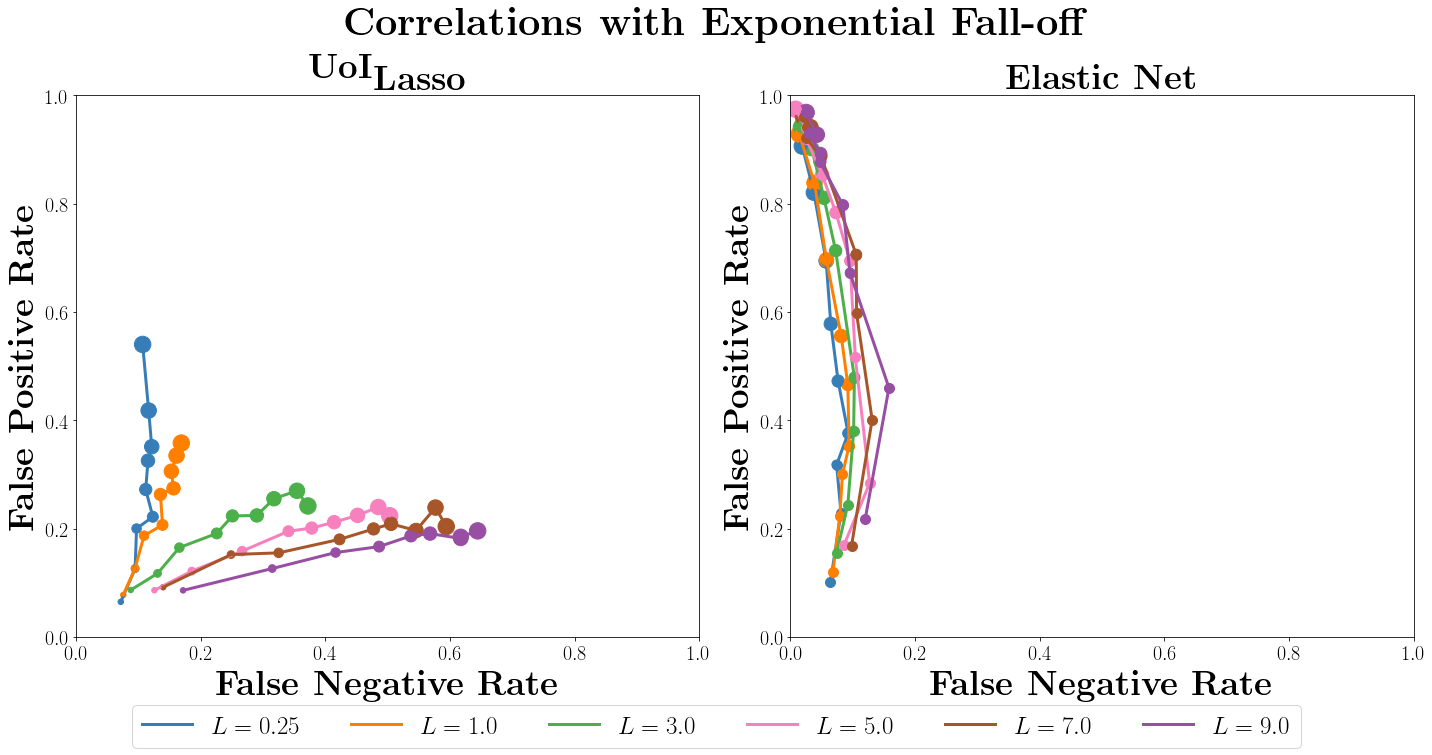

In [76]:
fig, axes = plot_fp_fn(sparsities=sparsities[:-1], Ls=np.array([0.25, 1.0, 3.0, 5.0, 7.0, 9.0]))
for ax in axes:
    ax.set_xlabel(r'\textbf{False Negative Rate}', fontsize=35)
    ax.set_ylabel(r'\textbf{False Positive Rate}', fontsize=35)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
axes[0].set_title(r'\textbf{UoI}$_{\textbf{Lasso}}$', fontsize=35)
axes[1].set_title(r'\textbf{Elastic Net}', fontsize=35)
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(
    handles, 
    labels, 
    loc='center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    prop={'size' : 25},
    bbox_transform=fig.transFigure
)
fig.suptitle(r'\textbf{Correlations with Exponential Fall-off}', fontsize=40)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('exp4_roc.pdf', bbox_inches='tight')

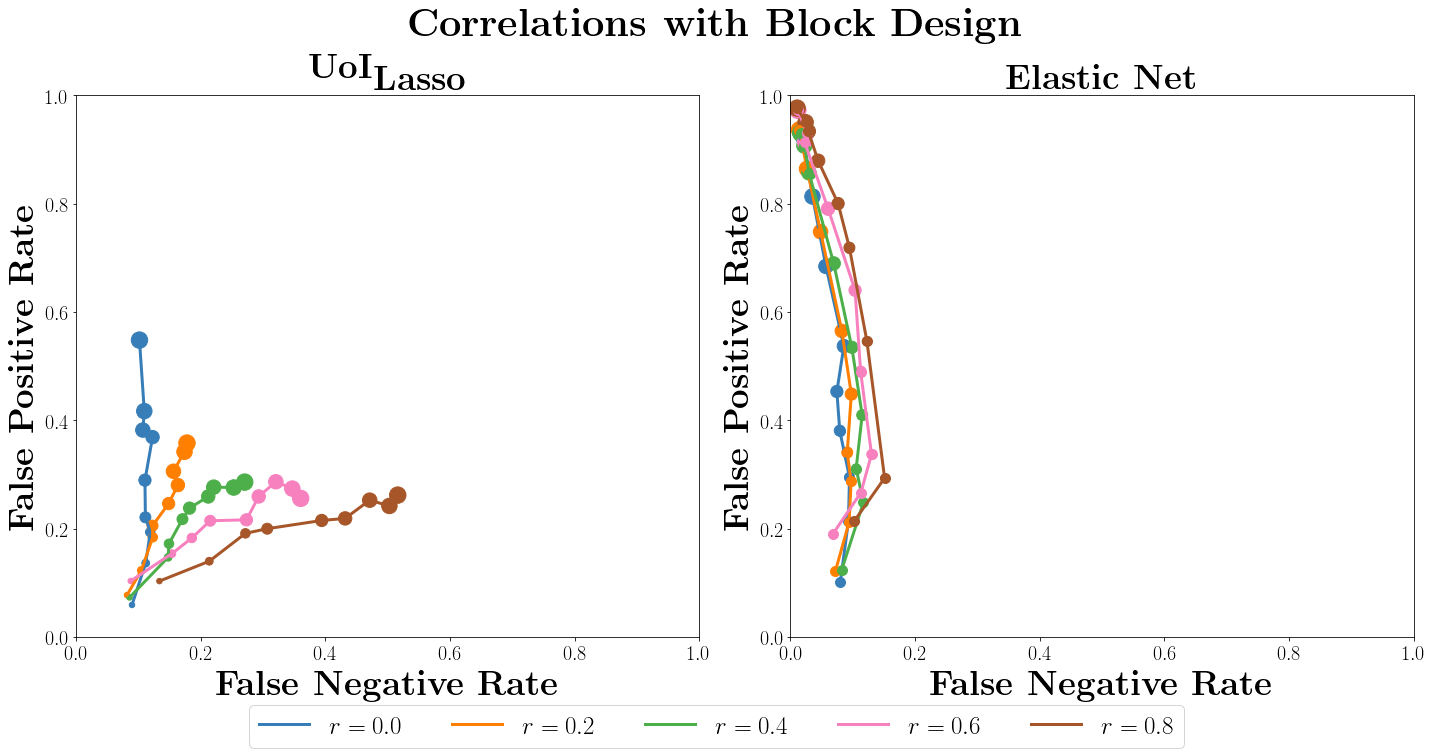

In [75]:
fig, axes = plot_fp_fn(sparsities=sparsities[:-1], correlations=np.array([0., 0.2, 0.4, 0.6, 0.8]))
for ax in axes:
    ax.set_xlabel(r'\textbf{False Negative Rate}', fontsize=35)
    ax.set_ylabel(r'\textbf{False Positive Rate}', fontsize=35)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
axes[0].set_title(r'\textbf{UoI}$_{\textbf{Lasso}}$', fontsize=35)
axes[1].set_title(r'\textbf{Elastic Net}', fontsize=35)
handles, labels = axes[0].get_legend_handles_labels()
lgd = fig.legend(
    handles, 
    labels, 
    loc='center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    prop={'size' : 25},
    bbox_transform=fig.transFigure
)
fig.suptitle(r'\textbf{Correlations with Block Design}', fontsize=40)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('exp5_roc.pdf', bbox_inches='tight')

# $R^2$ performance

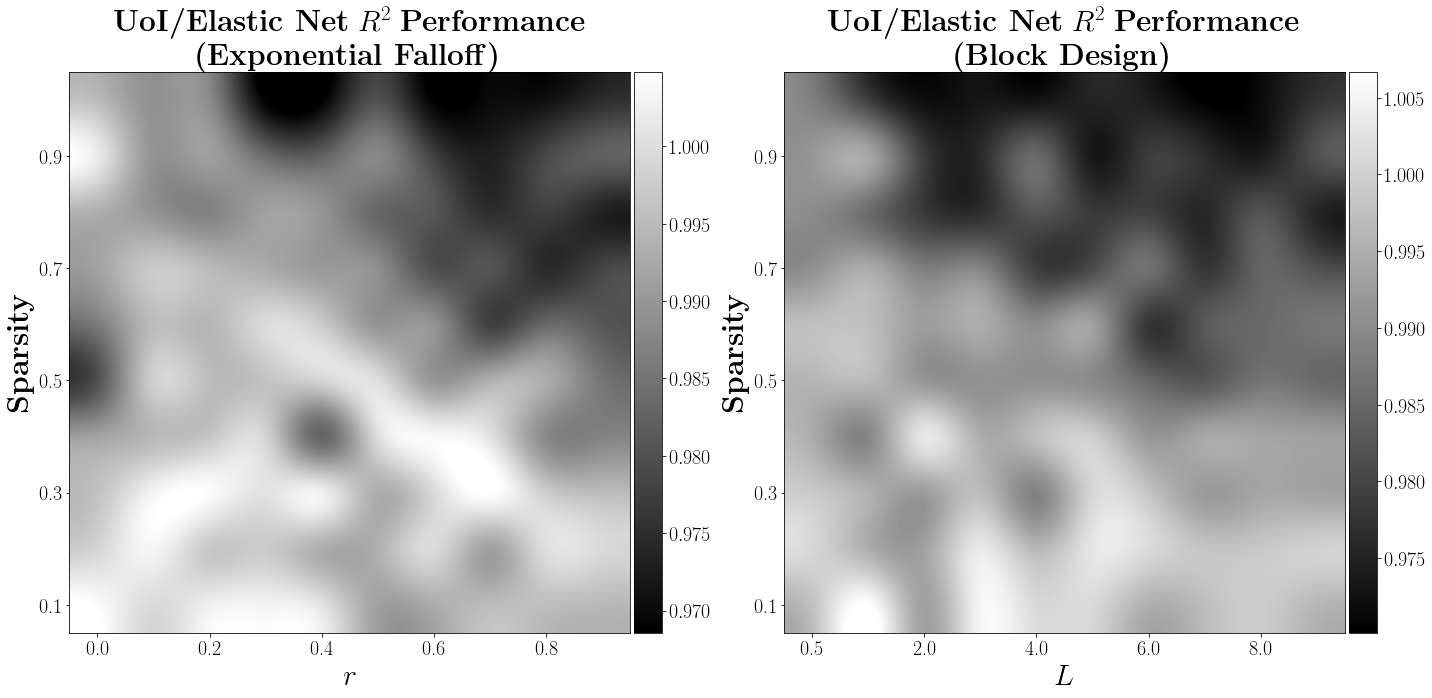

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

r2_true_L = np.zeros((sparsities.size, Ls.size))
r2_uoi_L = np.zeros((sparsities.size, Ls.size))
r2_enet_L = np.zeros((sparsities.size, Ls.size))

r2_true_r = np.zeros((sparsities.size, correlations.size))
r2_uoi_r = np.zeros((sparsities.size, correlations.size))
r2_enet_r = np.zeros((sparsities.size, correlations.size))

for sparsity_idx, sparsity in enumerate(sparsities):
    for corr_idx, correlation in enumerate(correlations):
        r2_true_r[sparsity_idx, corr_idx] = np.median(exp5[sparsity]['r2_true'][:, corr_idx])
        r2_uoi_r[sparsity_idx, corr_idx] = np.median(exp5[sparsity]['r2_uoi'][:, corr_idx])
        r2_enet_r[sparsity_idx, corr_idx] = np.median(exp5[sparsity]['r2_enet'][:, corr_idx])
        
for sparsity_idx, sparsity in enumerate(sparsities):
    for L_idx, L in enumerate(Ls):
        r2_true_L[sparsity_idx, L_idx] = np.median(exp4[sparsity]['r2_true'][:, L_idx])
        r2_uoi_L[sparsity_idx, L_idx] = np.median(exp4[sparsity]['r2_uoi'][:, L_idx])
        r2_enet_L[sparsity_idx, L_idx] = np.median(exp4[sparsity]['r2_enet'][:, L_idx])


img1 = axes[0].imshow(
    (r2_uoi_r/r2_enet_r)[:, :-1],
    interpolation='spline36'
)
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img1, cax=cax, orientation='vertical')
axes[0].set_xticks([0, 2, 4, 6, 8])
axes[0].set_xticklabels(correlations[[0, 2, 4, 6, 8]])
axes[0].set_xlabel(r'$r$')
axes[0].set_ylabel(r'\textbf{Sparsity}')
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[0].set_yticklabels(sparsities[[0, 2, 4, 6, 8]])
axes[0].set_title(r'\textbf{UoI/Elastic Net} $R^2$ \textbf{Performance}' '\n' r'\textbf{(Exponential Falloff)}')

img2 = axes[1].imshow(
    (r2_uoi_L/r2_enet_L)[:, 1:-1],
    interpolation='spline36'
)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img2, cax=cax, orientation='vertical')
axes[1].set_xticks([0, 2, 4, 6, 8])
axes[1].set_xticklabels(Ls[[1, 3, 5, 7, 9]])
axes[1].set_xlabel(r'$L$')
axes[1].set_ylabel(r'\textbf{Sparsity}')
axes[1].set_yticks([0, 2, 4, 6, 8])
axes[1].set_yticklabels(sparsities[[0, 2, 4, 6, 8]])
axes[1].set_title(r'\textbf{UoI/Elastic Net} $R^2$ \textbf{Performance}' '\n' r'\textbf{(Block Design)}')

plt.tight_layout()
plt.savefig('r2_exp4_exp5.pdf')